In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import requests
from io import BytesIO
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

In [20]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Preprocessing Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [3]:
# Load the training data
train_data = datasets.ImageFolder(root='../input/firerisk-balanced-data/train', transform=transform)

# Set up DataLoader for batching
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

In [4]:
# Load the validation data
val_data = datasets.ImageFolder(root='../input/firerisk-balanced-data/val', transform=transform)

# Set up DataLoader for batching
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)

In [5]:
# Updated MaskedAutoencoder with a more complex encoder
class MaskedAutoencoder(nn.Module):
    def __init__(self, num_classes=7):
        super(MaskedAutoencoder, self).__init__()
        
        # Updated Encoder for more capacity
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),  # Increased latent representation size
            nn.ReLU()
        )
        
        # Decoder for autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 256 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # 64 -> 128
            nn.Sigmoid()  # Output range [0, 1]
        )
        
        # Classification head
        self.classifier = nn.Linear(512, num_classes)  # 512 latent features -> num_classes

    def forward(self, x):
        # Encoder (shared for autoencoder and classification)
        encoded = self.encoder(x)
        
        # Decoder (for image reconstruction)
        reconstructed = self.decoder(encoded)
        
        # Classification head (for predicting the class)
        class_logits = self.classifier(encoded)
        
        return reconstructed, class_logits


In [16]:
# Instantiate and set the device to CPU
device = torch.device("cuda")
model = MaskedAutoencoder().to(device)

# Define the loss function and optimizer
reconstruction_criterion = nn.MSELoss()  # For autoencoder reconstruction
classification_criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

MaskedAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16384, out_features=512, bias=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=16384, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 8, 8))
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), 

In [17]:
def train_model(model, train_loader, reconstruction_criterion, classification_criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    
    # Scheduler for learning rate decay
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust learning rate every 5 epochs
    
    # Lists to store loss and accuracy values for each epoch
    epoch_losses = []
    epoch_recon_losses = []
    epoch_class_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_recon_loss = 0.0
        running_class_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, class_logits = model(images)
            
            # Compute the reconstruction loss
            recon_loss = reconstruction_criterion(reconstructed, images)
            
            # Compute the classification loss
            class_loss = classification_criterion(class_logits, labels)
            
            # Combine the two losses, weighting classification loss if desired
            total_loss = recon_loss + 2 * class_loss
            
            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            # Accumulate the losses for logging
            running_loss += total_loss.item()
            running_recon_loss += recon_loss.item()
            running_class_loss += class_loss.item()
            
            # Calculate accuracy for the batch
            _, predicted_labels = torch.max(class_logits, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)
        
        # Step the scheduler
        scheduler.step()
        
        # Calculate average losses and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_recon_loss = running_recon_loss / len(train_loader)
        epoch_class_loss = running_class_loss / len(train_loader)
        epoch_accuracy = (correct_predictions / total_samples) * 100
        
        # Append metrics to lists
        epoch_losses.append(epoch_loss)
        epoch_recon_losses.append(epoch_recon_loss)
        epoch_class_losses.append(epoch_class_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        # Print metrics for the current epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, Recon Loss: {epoch_recon_loss:.4f}, Class Loss: {epoch_class_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    print("Training complete!")
    
    # Return the loss and accuracy lists
    return epoch_losses, epoch_recon_losses, epoch_class_losses, epoch_accuracies

In [18]:
# Training the model
num_epochs = 15  # Set number of epochs
epoch_losses, epoch_recon_losses, epoch_class_losses, epoch_accuracies = train_model(model, train_loader, reconstruction_criterion, classification_criterion, optimizer, num_epochs)

Epoch [1/15], Total Loss: 3.4436, Recon Loss: 0.1765, Class Loss: 1.6335, Accuracy: 32.44%, LR: 0.001000
Epoch [2/15], Total Loss: 3.1276, Recon Loss: 0.1606, Class Loss: 1.4835, Accuracy: 38.56%, LR: 0.001000
Epoch [3/15], Total Loss: 3.0329, Recon Loss: 0.1605, Class Loss: 1.4362, Accuracy: 40.24%, LR: 0.001000
Epoch [4/15], Total Loss: 3.0019, Recon Loss: 0.1606, Class Loss: 1.4206, Accuracy: 41.31%, LR: 0.001000
Epoch [5/15], Total Loss: 2.9407, Recon Loss: 0.1606, Class Loss: 1.3901, Accuracy: 42.94%, LR: 0.000100
Epoch [6/15], Total Loss: 2.6934, Recon Loss: 0.1606, Class Loss: 1.2664, Accuracy: 47.99%, LR: 0.000100
Epoch [7/15], Total Loss: 2.6235, Recon Loss: 0.1605, Class Loss: 1.2315, Accuracy: 49.10%, LR: 0.000100
Epoch [8/15], Total Loss: 2.5752, Recon Loss: 0.1605, Class Loss: 1.2074, Accuracy: 50.13%, LR: 0.000100
Epoch [9/15], Total Loss: 2.5197, Recon Loss: 0.1606, Class Loss: 1.1796, Accuracy: 51.31%, LR: 0.000100
Epoch [10/15], Total Loss: 2.4610, Recon Loss: 0.1605, 

Text(0.5, 1.0, 'Training Loss')

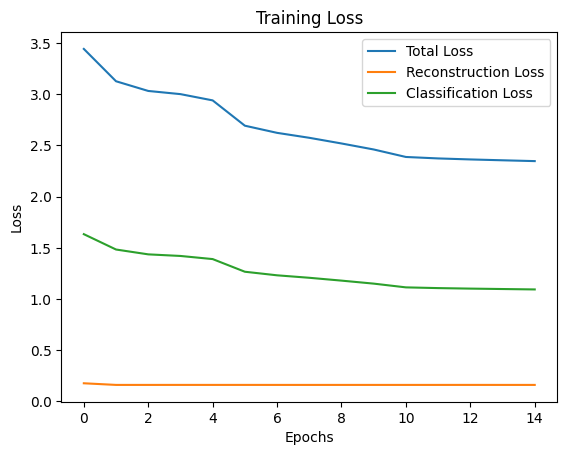

In [19]:
# Loss plot
plt.plot(epoch_losses, label="Total Loss")
plt.plot(epoch_recon_losses, label="Reconstruction Loss")
plt.plot(epoch_class_losses, label="Classification Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

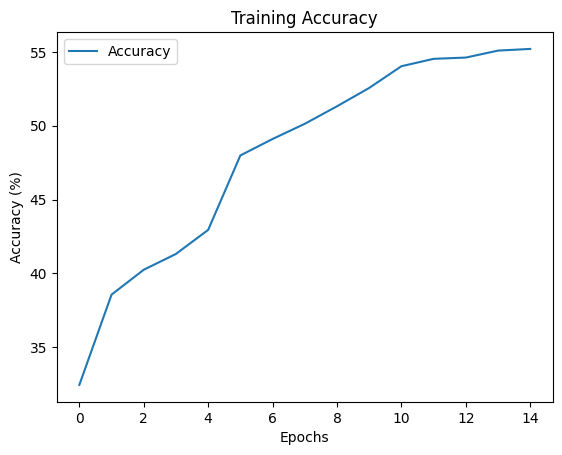

In [20]:
 # Accuracy plot
plt.plot(epoch_accuracies, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training Accuracy")

In [ ]:
# Save the model
torch.save(model.state_dict(), open('/kaggle/working/trained_model.pth'))
print("Model saved successfully!")

In [21]:
def validate_model(model, val_loader, reconstruction_criterion, classification_criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_recon_loss = 0.0
    total_class_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # No gradient calculation needed during validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            reconstructed, class_logits = model(images)
            
            # Compute reconstruction loss
            recon_loss = reconstruction_criterion(reconstructed, images)
            
            # Compute classification loss
            class_loss = classification_criterion(class_logits, labels)
            
            # Combine losses
            total_batch_loss = recon_loss + 2*class_loss
            
            # Accumulate the losses for logging
            total_loss += total_batch_loss.item()
            total_recon_loss += recon_loss.item()
            total_class_loss += class_loss.item()
            
            # Compute accuracy for classification
            _, predicted_labels = torch.max(class_logits, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)
    
    # Calculate average losses
    avg_val_loss = total_loss / len(val_loader)
    avg_recon_loss = total_recon_loss / len(val_loader)
    avg_class_loss = total_class_loss / len(val_loader)
    
    # Calculate accuracy
    accuracy = (correct_predictions / total_samples) * 100
    
    print(f"Validation Results - Loss: {avg_val_loss:.4f} | Recon Loss: {avg_recon_loss:.4f} | "
          f"Class Loss: {avg_class_loss:.4f} | Accuracy: {accuracy:.2f}%")


In [22]:
# Validate the model after training
validate_model(model, val_loader, reconstruction_criterion, classification_criterion)

Validation Results - Loss: 3.0130 | Recon Loss: 0.1352 | Class Loss: 1.4389 | Accuracy: 41.43%


In [13]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_true_labels = []
    all_predicted_labels = []

    total_samples = 0

    with torch.no_grad():  # No gradient calculation needed during evaluation
        for images, labels in data_loader:
            images = images.to(device)  # Move images to the appropriate device
            labels = labels.to(device)

            # Forward pass
            reconstructed, class_logits = model(images)
            
            # Calculate classification predictions
            _, predicted_labels = torch.max(class_logits, 1)  # Get the predicted class
            
            # Collect true and predicted labels
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision = precision_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)

    # Print results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    return all_true_labels , all_predicted_labels

In [14]:
# Evaluate the model on the validation set
y_true , y_pred = evaluate_model(model, val_loader)

Accuracy: 0.4343
Precision: 0.4196
Recall: 0.4343
F1 Score: 0.4235


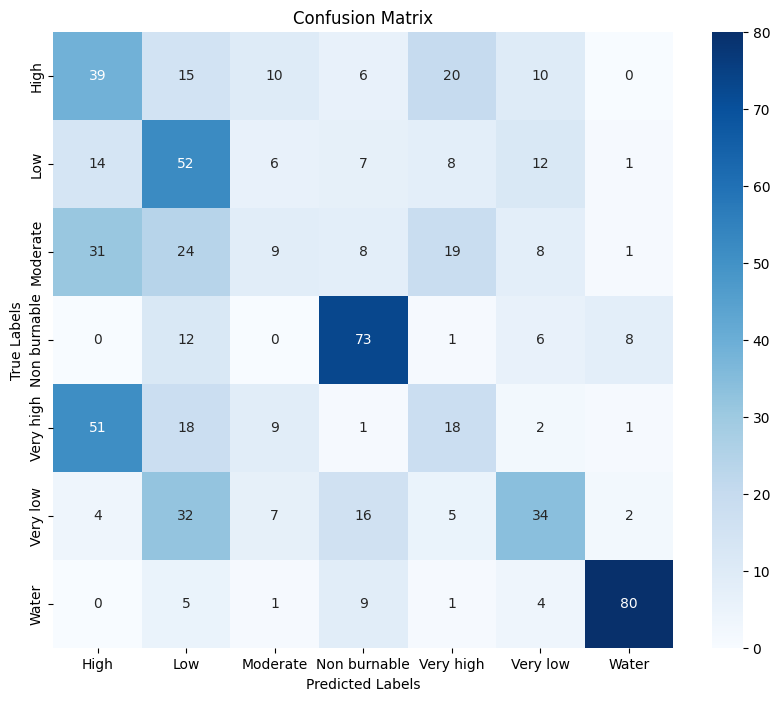

In [20]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['High', 'Low', 'Moderate', 'Non burnable', 'Very high', 'Very low', 'Water']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Fairlearn metric
metrics_dict = {
    "Equalized Odds Difference": equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features),
    "False Negative Rate Difference": false_negative_rate_difference(y_true, y_pred, sensitive_features=sensitive_features),
    "True Positive Rate Difference": true_positive_rate_difference(y_true, y_pred, sensitive_features=sensitive_features),
    "Accuracy Score Group Min": accuracy_score_group_min(y_true, y_pred, sensitive_features=sensitive_features)
}

NameError: name 'sensitive_features' is not defined

In [ ]:
for metric, value in metrics_dict.items():
    print(f"{metric}: {value}")